In [1]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random

### 실제 데이터 소스

- 실제 데이터는 정확한 값으로 떨어질 확률이 거의 없기 때문에 약간의 임의성 추가

In [2]:
def generate_real():
    real_data = torch.FloatTensor(
        [
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
            random.uniform(0.8, 1.0),
            random.uniform(0.0, 0.2),
        ])               # torch.FloatTensor([1, 0, 1, 0])
    return real_data

generate_real()

tensor([0.9256, 0.1478, 0.9908, 0.1718])

### 판별기 만들기

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )

        # 손실합수 옵티마이저 설정
        self.loss_function = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        # 훈련 과정 추적을 위한 변수
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        return self.model(inputs)

    def train(self, inputs, targets):
        # 출력 계산
        outputs = self.forward(inputs)

        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)

        # 기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5))

### 판별기 테스트
- 1010 패턴 데이터는 진짜이므로 목표 출력 1,0
- 임의의 노이즈 데이터는 가짜이므로 목표출력 0,0

In [20]:
def generate_random(size):
    random_data = torch.rand(size) # 노이즈 페턴을 반환
    return random_data

generate_random(4)

tensor([0.3843, 0.6799, 0.8367, 0.6946])

counter =  10000
counter =  20000


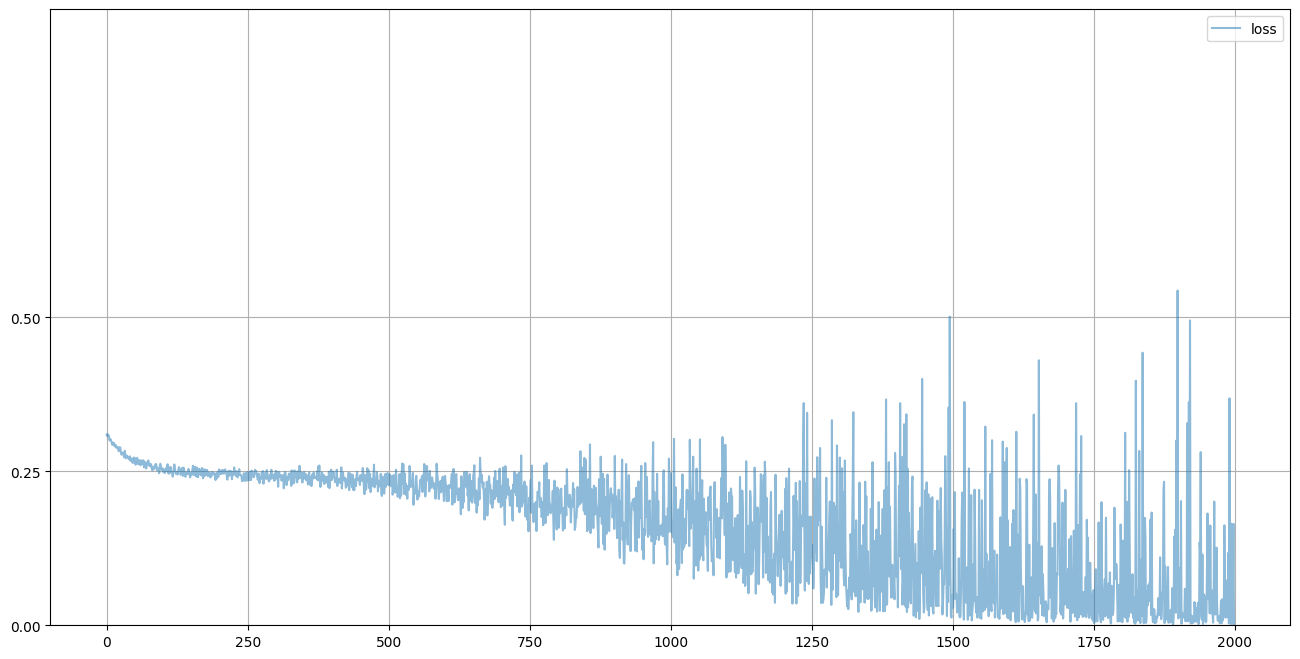

In [22]:
# 훈련 반복문
D = Discriminator()
for i in range(10000):
    # real data
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.FloatTensor([0.0]))

# 차트 확인
D.plot_progress()

In [24]:
# real data와 fake data를 잘 구분하는 지 확인
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

0.7979221940040588
0.11722822487354279


- 점점더 1010 패턴에 적응하기 시작함
- 판별기가 잘 활동

### 생성기 만들기
- layer
  - 출력레이어는 실제 데이터와 일치하도록 4개의 노드가 필요함
  - 판별기나 생성기 어느 한쪽이 앞서면 안되기 때문에 많은 연구자들은 판별기를 복사해서 작업을 시작하곤 함
- loss
  - 손실함수는 판별기로부터 흘러온 기울기 오차를 통해 업데이트

In [28]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # 옵티마이저 설정 (손실함수는 설정하지 않음)
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

        # 훈련 과정 추적을 위한 변수
        self.counter = 0
        self.progress = []

    def forward(self, inputs): # 가독성을 키우기 위해 다음과 같이 사용
        return self.model(inputs)

    def train(self, D, inputs, targets):
        # 생성기 출력 계산
        g_outputs = self.forward(inputs)

        # 생성기 출력값을 판별기로 전달
        d_outputs = D.forward(g_outputs)

        # 오차 계산
        loss = D.loss_function(d_outputs, targets)

        # 오차 저장
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        # if (self.counter % 10000 == 0): # 판별기 학습 코드에 출력문이 있기 때문에 중복 출력 방지
        #     print("counter = ", self.counter)

        # 기울기 초기화, 역전파, 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5))

### 생성기 결과 확인
- input = 0.5
  - 다른 신경망과 같이 입력값이 필요
  - 제일 간단하게 상수하나 (큰값은 훈련을 힘들게 하니 적당하게)

In [29]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.6851, 0.3798, 0.6336, 0.5555], grad_fn=<SigmoidBackward0>)

### GAN 훈련

In [40]:
import numpy

In [41]:
%%time

# 훈련 반복문
D = Discriminator()
G = Generator()
image_list = []
for i in range(10000):
    # 1단계: real data에 대해 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))
    # 2단계: fake data에 대해 판별기 훈련
    # G의 기울기가 계산 되지 않도록 detach 사용
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    # 3단계: 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))

    # 결과 확인을 위한 저장
    if (i % 1000 == 0):
        image_list.append(G.forward(torch.FloatTensor([0.5])).detach().numpy())


counter =  10000
counter =  20000
CPU times: user 18.8 s, sys: 29.9 ms, total: 18.9 s
Wall time: 19 s


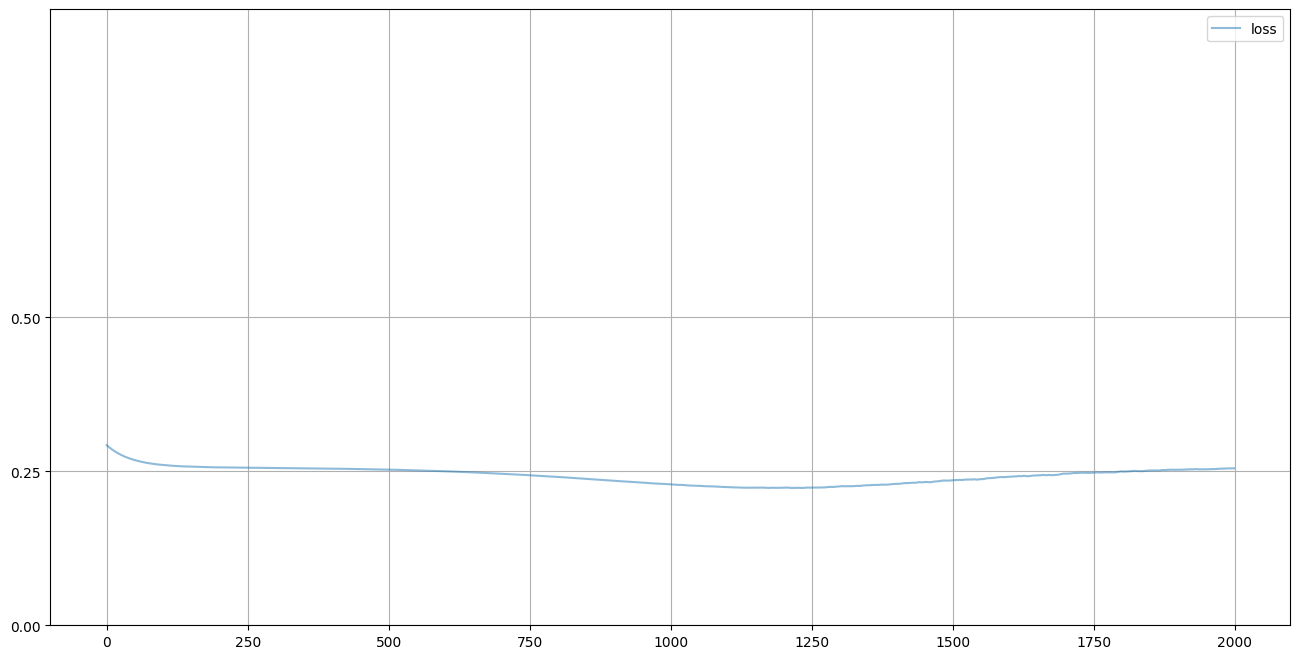

In [44]:
D.plot_progress()

- 훈련이 진행됨에도 손실이 0응 향하지 않음
- 손실이 0.25에서 벗어나지 않음
  - 확실한 결과가 아닌 애매한 0.5라는 결과
    - 실제 조작된 데이터를 잘 판별하지 못함
    - 평균제곱오차(MSE)를 사용하기 때문에 손실이 0.25로 나옴
  - 즉, 생성기가 판별기가 구별하기 쉽지 않은 데이터를 만들어 내고 있음

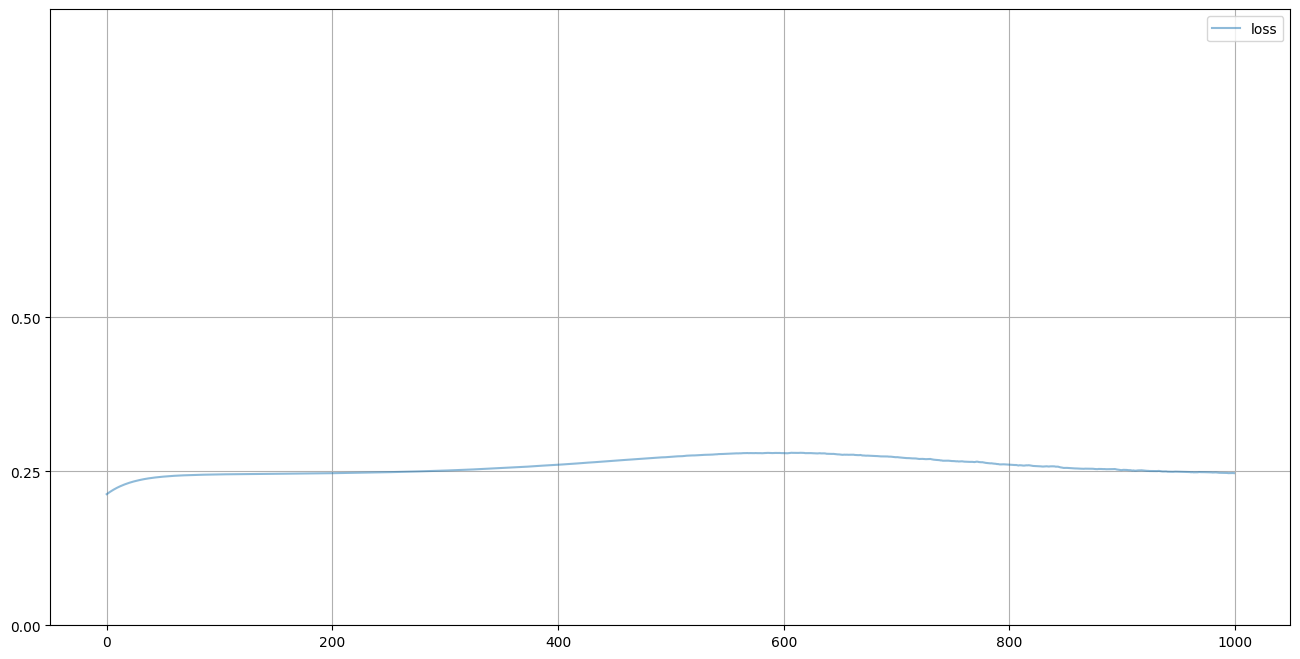

In [45]:
G.plot_progress()

- 0.25 보다 크다
  - 판별기가 가짜인지 진짜인지 잘 분류를 못한다.
  - 판별기를 속일 수 있을 정도로 성능이 향상됨
- 전체적으로 균형을 이룸

# 결과 확인해보기

In [46]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.8799, 0.0722, 0.8758, 0.0732], grad_fn=<SigmoidBackward0>)

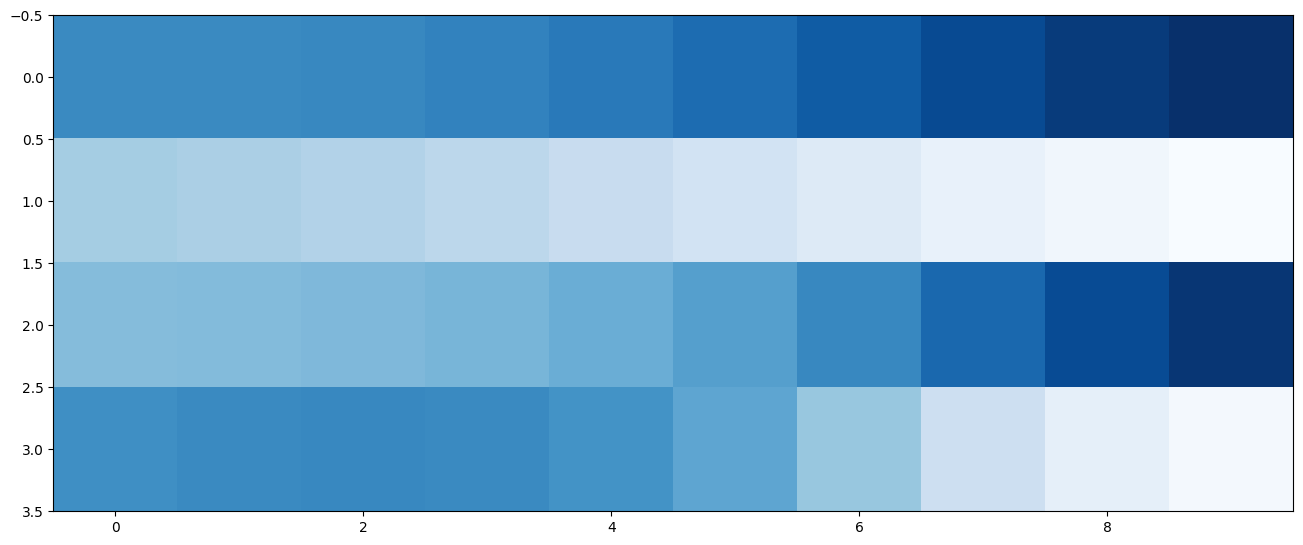

In [47]:
plt.figure(figsize=(16, 8))
plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')